## NYC Yellow and green taxi trip records analysis
In this notebook, an analysis will be carried out based on New York taxi data.<br>
The goal will be to study the data set to create statistics sets. After that, based on the received data, we will create data sets for the statistics of the report that will be used in API

Content:
1. Analysis and data visualisation
2. Data preparation
3. Machine learning model creation
4. Model implementation
5. Functions preparation

In [54]:
import numpy as np
import pandas as pd
import pyarrow
from datetime import datetime
import datetime as dt

In [55]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

In [56]:
print(np.__version__)
print(pd.__version__)
print(pyarrow.__version__)
print(matplotlib.__version__)
print(sns.__version__)

1.20.3
1.3.2
9.0.0
3.4.3
0.11.2


In [57]:
import warnings
warnings.filterwarnings('ignore')

In [58]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [59]:
df = pd.read_parquet("../data/yellow_tripdata_2022-05.parquet")

In [60]:
#temp
#df = df.iloc[0:300000]

In [61]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-05-01 00:00:36,2022-05-01 00:19:18,1.0,4.1,1.0,N,246,151,2,17.0,3.0,0.5,0.00,0.0,0.3,20.80,2.5,0.0
1,1,2022-05-01 00:27:44,2022-05-01 00:41:33,1.0,2.3,1.0,N,238,74,2,11.0,3.0,0.5,0.00,0.0,0.3,14.80,2.5,0.0
2,1,2022-05-01 00:59:00,2022-05-01 01:14:22,1.0,4.2,1.0,N,163,260,2,15.5,3.0,0.5,0.00,0.0,0.3,19.30,2.5,0.0
3,1,2022-05-01 00:48:18,2022-05-01 01:28:02,1.0,0.0,1.0,N,79,182,1,41.2,0.0,0.5,0.00,0.0,0.3,42.00,0.0,0.0
4,1,2022-05-01 00:28:26,2022-05-01 00:37:49,1.0,1.6,1.0,N,238,75,1,7.5,3.0,0.5,2.25,0.0,0.3,13.55,2.5,0.0


In [62]:
#convert miles to km
df['trip_distance'] = df['trip_distance'] * 1.60934

Primary Analysis

In [63]:
print('We have {} rows and {} colums'.format(df.shape[0], df.shape[1]))
print('No missing values.') if not df.isnull().values.any() else print('There are missing values')
print('The store_and_fwd_flag has values {}.'.format(str(set(df.store_and_fwd_flag.unique()))))

We have 3588295 rows and 19 colums
There are missing values
The store_and_fwd_flag has values {'Y', 'N', None}.


In [64]:
df['tpep_pickup_datetime'] = pd.to_datetime(df.tpep_pickup_datetime)
df['tpep_dropoff_datetime'] = pd.to_datetime(df.tpep_dropoff_datetime)

In [65]:
df['trip_duration_seconds'] = df.apply(lambda x: (x.tpep_dropoff_datetime - x.tpep_pickup_datetime).total_seconds(), axis=1)

In [66]:
df['trip_duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']

In [67]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_seconds,trip_duration
0,1,2022-05-01 00:00:36,2022-05-01 00:19:18,1.0,6.598294,1.0,N,246,151,2,17.0,3.0,0.5,0.00,0.0,0.3,20.80,2.5,0.0,1122.0,0 days 00:18:42
1,1,2022-05-01 00:27:44,2022-05-01 00:41:33,1.0,3.701482,1.0,N,238,74,2,11.0,3.0,0.5,0.00,0.0,0.3,14.80,2.5,0.0,829.0,0 days 00:13:49
2,1,2022-05-01 00:59:00,2022-05-01 01:14:22,1.0,6.759228,1.0,N,163,260,2,15.5,3.0,0.5,0.00,0.0,0.3,19.30,2.5,0.0,922.0,0 days 00:15:22
3,1,2022-05-01 00:48:18,2022-05-01 01:28:02,1.0,0.000000,1.0,N,79,182,1,41.2,0.0,0.5,0.00,0.0,0.3,42.00,0.0,0.0,2384.0,0 days 00:39:44
4,1,2022-05-01 00:28:26,2022-05-01 00:37:49,1.0,2.574944,1.0,N,238,75,1,7.5,3.0,0.5,2.25,0.0,0.3,13.55,2.5,0.0,563.0,0 days 00:09:23


In [68]:
#convert the time data and see the maximum and minimum values
print("Max and min distance (km): {}, {}".format(df['trip_distance'].max(), df['trip_distance'].min()))
print("Max and min times (sec): {}, {}".format(df['trip_duration_seconds'].max(), df['trip_duration_seconds'].min()))

Max and min distance (km): 574844.419351, 0.0
Max and min times (sec): 409413.0, -845.0


The data doens't looks normalized. To do this, clean their edges

In [69]:
#Immediately discard the time data that is below zero
df = df[df['trip_duration_seconds'] > 0]

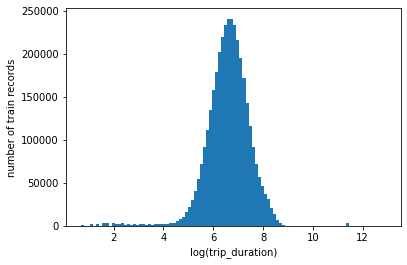

In [70]:
#visualize the distribution
df['log_trip_duration'] = np.log(df['trip_duration_seconds'].values + 1)
plt.hist(df['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

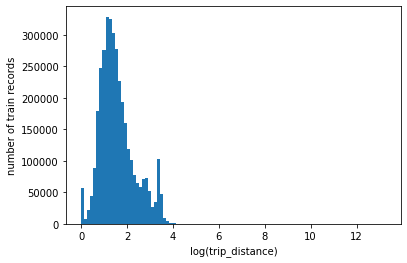

In [71]:
#visualize the distribution
df['log_trip_distance'] = np.log(df['trip_distance'].values + 1)
plt.hist(df['log_trip_distance'].values, bins=100)
plt.xlabel('log(trip_distance)')
plt.ylabel('number of train records')
plt.show()

As you can see from the graphs, the data still has outliers, so let's clean them up

In [72]:
# remove outliers
durLimits  = [np.percentile(df['trip_duration_seconds'], 2), np.percentile(df['trip_duration_seconds'], 98.5)]
df = df[(df['trip_duration_seconds'] >= durLimits[0]) & (df['trip_duration_seconds'] <= durLimits[1])]

distLimits  = [np.percentile(df['trip_distance'], 1), np.percentile(df['trip_distance'], 98.5)]
df = df[(df['trip_distance'] >= distLimits[0]) & (df['trip_distance'] <= distLimits[1])]

df = df.reset_index(drop=True)

In [73]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_seconds,trip_duration,log_trip_duration,log_trip_distance
0,1,2022-05-01 00:00:36,2022-05-01 00:19:18,1.0,6.598294,1.0,N,246,151,2,17.0,3.0,0.5,0.00,0.0,0.3,20.80,2.5,0.0,1122.0,0 days 00:18:42,7.023759,2.027924
1,1,2022-05-01 00:27:44,2022-05-01 00:41:33,1.0,3.701482,1.0,N,238,74,2,11.0,3.0,0.5,0.00,0.0,0.3,14.80,2.5,0.0,829.0,0 days 00:13:49,6.721426,1.547878
2,1,2022-05-01 00:59:00,2022-05-01 01:14:22,1.0,6.759228,1.0,N,163,260,2,15.5,3.0,0.5,0.00,0.0,0.3,19.30,2.5,0.0,922.0,0 days 00:15:22,6.827629,2.048883
3,1,2022-05-01 00:28:26,2022-05-01 00:37:49,1.0,2.574944,1.0,N,238,75,1,7.5,3.0,0.5,2.25,0.0,0.3,13.55,2.5,0.0,563.0,0 days 00:09:23,6.335054,1.273950
4,2,2022-04-30 23:53:47,2022-05-01 00:05:17,1.0,3.009466,1.0,N,249,164,1,9.5,0.5,0.5,2.66,0.0,0.3,15.96,2.5,0.0,690.0,0 days 00:11:30,6.538140,1.388658


In [74]:
#convert the time data and see the maximum and minimum values
print("Max and min distance (km): {}, {}".format(df['trip_distance'].max(), df['trip_distance'].min()))
print("Max and min times (sec): {}, {}".format(df['trip_duration_seconds'].max(), df['trip_duration_seconds'].min()))

Max and min distance (km): 30.255592, 0.5310822000000001
Max and min times (sec): 3884.0, 117.0


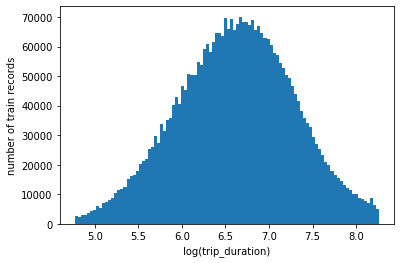

In [75]:
#visualize the distribution
plt.hist(df['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

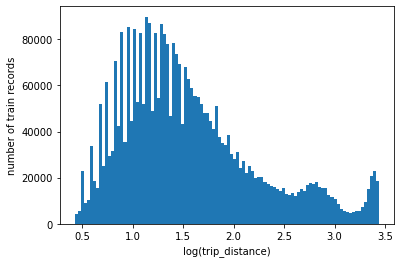

In [76]:
#visualize the distribution
plt.hist(df['log_trip_distance'].values, bins=100)
plt.xlabel('log(trip_distance)')
plt.ylabel('number of train records')
plt.show()

In [77]:
df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
df['pickup_hour_weekofyear'] = df['tpep_pickup_datetime'].dt.weekofyear
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
df['pickup_dt'] = (df['tpep_pickup_datetime'] - df['tpep_pickup_datetime'].min()).dt.total_seconds()
df['pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']

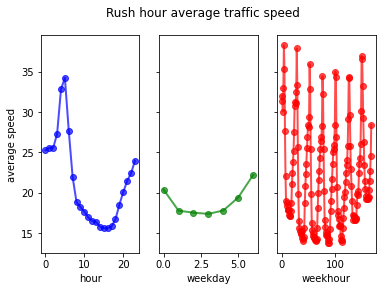

In [24]:
#find average speeds at different times
df.loc[:, 'avg_speed_h'] = df['trip_distance'] / (df['trip_duration_seconds'] / 3600)
df.loc[:, 'avg_speed_m'] = df['trip_distance'] / (df['trip_duration_seconds'] / 60)


fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(df.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(df.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(df.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

### Prepare data

Get statistikal data based on avegare speed

In [25]:
df_hours = df.groupby('pickup_hour').mean()['avg_speed_h']
df_weekday = df.groupby('pickup_weekday').mean()['avg_speed_h']
df_weekday_hour = df.groupby('pickup_week_hour').mean()['avg_speed_h']

In [26]:
average_speed_hour_dict = df_hours.to_dict()
average_speed_weekday_dict = df_weekday.to_dict()
average_speed_weekday_hour_dict = df_weekday_hour.to_dict()

In [27]:
df["avg_speed_this_hour"] = df['pickup_hour'].map(average_speed_hour_dict)
df["avg_speed_this_day"] = df['pickup_weekday'].map(average_speed_weekday_dict)
df["avg_speed_this_dayweek"] = df['pickup_week_hour'].map(average_speed_weekday_hour_dict)

In [28]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_seconds,trip_duration,log_trip_duration,log_trip_distance,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,avg_speed_h,avg_speed_m,avg_speed_this_hour,avg_speed_this_day,avg_speed_this_dayweek
0,1,2022-05-01 00:00:36,2022-05-01 00:19:18,1.0,6.598294,1.0,N,246,151,2,17.0,3.0,0.5,0.00,0.0,0.3,20.80,2.5,0.0,1122.0,0 days 00:18:42,7.023759,2.027924,6,17,0,0,609983670.0,144,21.170997,0.352850,25.262018,22.201269,22.424420
1,1,2022-05-01 00:27:44,2022-05-01 00:41:33,1.0,3.701482,1.0,N,238,74,2,11.0,3.0,0.5,0.00,0.0,0.3,14.80,2.5,0.0,829.0,0 days 00:13:49,6.721426,1.547878,6,17,0,27,609985298.0,144,16.073987,0.267900,25.262018,22.201269,22.424420
2,1,2022-05-01 00:59:00,2022-05-01 01:14:22,1.0,6.759228,1.0,N,163,260,2,15.5,3.0,0.5,0.00,0.0,0.3,19.30,2.5,0.0,922.0,0 days 00:15:22,6.827629,2.048883,6,17,0,59,609987174.0,144,26.391780,0.439863,25.262018,22.201269,22.424420
3,1,2022-05-01 00:28:26,2022-05-01 00:37:49,1.0,2.574944,1.0,N,238,75,1,7.5,3.0,0.5,2.25,0.0,0.3,13.55,2.5,0.0,563.0,0 days 00:09:23,6.335054,1.273950,6,17,0,28,609985340.0,144,16.465006,0.274417,25.262018,22.201269,22.424420
4,2,2022-04-30 23:53:47,2022-05-01 00:05:17,1.0,3.009466,1.0,N,249,164,1,9.5,0.5,0.5,2.66,0.0,0.3,15.96,2.5,0.0,690.0,0 days 00:11:30,6.538140,1.388658,5,17,23,53,609983261.0,143,15.701561,0.261693,23.967239,19.408069,20.252859


In [29]:
df.dropna(inplace=True)

In [30]:
store_map = {"Y": 1, "N": 0}
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map(store_map)

In [31]:
y = df.trip_duration
del df['trip_duration']

In [32]:
y = y.dt.total_seconds()

In [33]:
df.head(3)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_seconds,log_trip_duration,log_trip_distance,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,avg_speed_h,avg_speed_m,avg_speed_this_hour,avg_speed_this_day,avg_speed_this_dayweek
0,1,2022-05-01 00:00:36,2022-05-01 00:19:18,1.0,6.598294,1.0,0,246,151,2,17.0,3.0,0.5,0.0,0.0,0.3,20.8,2.5,0.0,1122.0,7.023759,2.027924,6,17,0,0,609983670.0,144,21.170997,0.352850,25.262018,22.201269,22.42442
1,1,2022-05-01 00:27:44,2022-05-01 00:41:33,1.0,3.701482,1.0,0,238,74,2,11.0,3.0,0.5,0.0,0.0,0.3,14.8,2.5,0.0,829.0,6.721426,1.547878,6,17,0,27,609985298.0,144,16.073987,0.267900,25.262018,22.201269,22.42442
2,1,2022-05-01 00:59:00,2022-05-01 01:14:22,1.0,6.759228,1.0,0,163,260,2,15.5,3.0,0.5,0.0,0.0,0.3,19.3,2.5,0.0,922.0,6.827629,2.048883,6,17,0,59,609987174.0,144,26.391780,0.439863,25.262018,22.201269,22.42442


In [34]:
mapp = {0:1, 1:1, 2:1, 3:1, 4:1, 5:1, 6:1}
map1 = {0 : 1}
map2 = {1 : 1}
map3 = {2 : 1}
map4 = {3 : 1}
map5 = {4 : 1}
map6 = {5 : 1}
map7 = {6 : 1}
df['Monday'] = df['pickup_weekday'].map(map1)
df['Tuesday'] = df['pickup_weekday'].map(map2)
df['Wednesda'] = df['pickup_weekday'].map(map3)
df['Thursday'] = df['pickup_weekday'].map(map4)
df['Friday'] = df['pickup_weekday'].map(map5)
df['Saturday'] = df['pickup_weekday'].map(map6)
df['Sunday'] = df['pickup_weekday'].map(map7)
df.fillna(0, inplace=True)

In [35]:
df_train=df[['trip_distance', 'PULocationID', 'DOLocationID', 'pickup_weekday', 'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'avg_speed_this_hour', 'avg_speed_this_day', 'avg_speed_this_dayweek']]

In [36]:
df_train.head(3)

,trip_distance,PULocationID,DOLocationID,pickup_weekday,pickup_hour,pickup_minute,pickup_week_hour,avg_speed_this_hour,avg_speed_this_day,avg_speed_this_dayweek
0,6.598294,246,151,6,0,0,144,25.262018,22.201269,22.42442
1,3.701482,238,74,6,0,27,144,25.262018,22.201269,22.42442
2,6.759228,163,260,6,0,59,144,25.262018,22.201269,22.42442


### Prepare model

For this data I will use Random Tree Forest

In [37]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate 
from sklearn.metrics import mean_squared_error, make_scorer, r2_score 
from sklearn.ensemble import RandomForestRegressor

In [38]:
rfr = RandomForestRegressor(n_estimators=30, max_depth=18, n_jobs=-1, random_state=42)
kf = KFold(shuffle=True, n_splits = 5, random_state = 42)

In [39]:
mse_scorer = make_scorer(mean_squared_error)

Do a little validation to choose best model

In [40]:
for i in range(5, 20):
    rfr = RandomForestRegressor(n_estimators=5, max_depth=i, n_jobs=-1, random_state=42)
    print(i, cross_validate(estimator=rfr, X=df_train, y=y, cv=kf, n_jobs = -1, scoring=mse_scorer))

5 {'fit_time': array([112.01047063, 112.12253952, 112.07733917, 111.91498208,
       112.03947711]), 'score_time': array([0.48442888, 0.39654255, 0.4417429 , 0.60809922, 0.47742701]), 'test_score': array([96360.44874043, 96166.90191129, 96522.87019119, 96433.54322911,
       96498.55381003])}
6 {'fit_time': array([58.18373871, 55.07245684, 56.68571687, 57.88490343, 57.1568327 ]), 'score_time': array([0.11894655, 0.40967512, 0.27405572, 0.15119052, 0.22375202]), 'test_score': array([91654.92522705, 91633.5072616 , 92108.92679324, 91876.3321672 ,
       92060.31960683])}
7 {'fit_time': array([59.05445409, 60.51035166, 64.90648484, 65.8500073 , 66.08660245]), 'score_time': array([0.14761734, 0.17922425, 1.19316578, 0.47363877, 0.30129695]), 'test_score': array([88918.37987805, 88949.64165682, 89367.66729008, 89111.30328827,
       89375.71294517])}
8 {'fit_time': array([75.41081715, 69.6992476 , 76.36396146, 76.61546302, 75.01367617]), 'score_time': array([0.34365702, 0.39159155, 0.132363

In [41]:
rfr = RandomForestRegressor(n_estimators=5, max_depth=18, n_jobs=-1, random_state=42)
kf = KFold(shuffle=True, n_splits = 5, random_state = 42)
score = cross_val_score(estimator=rfr, X=df_train, y=y, cv=kf, n_jobs = -1, scoring=mse_scorer)
score.mean()

71309.81342915058

In [42]:
rfr.fit(df_train, y)

RandomForestRegressor(max_depth=18, n_estimators=5, n_jobs=-1, random_state=42)

In [43]:
y_pred = rfr.predict(df_train)

In [44]:
feature_importances = pd.DataFrame(rfr.feature_importances_,
                                   index = df_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

In [45]:
#check the most important data
feature_importances.head(10)

,importance
trip_distance,0.811823
avg_speed_this_dayweek,0.096498
DOLocationID,0.033220
PULocationID,0.027630
pickup_minute,0.011702
pickup_hour,0.007038
pickup_week_hour,0.004855
avg_speed_this_hour,0.004299
avg_speed_this_day,0.001787
pickup_weekday,0.001146


In [46]:
y_pred

array([1169.03492401,  708.27179811, 1064.77662304, ...,  901.66373547,
        240.94294788,  325.68      ])

In [47]:
y

0          1122.0
1           829.0
2           922.0
3           563.0
4           690.0
            ...  
3254427     331.0
3254428     389.0
3254429     816.0
3254430     191.0
3254431     316.0
Name: trip_duration, Length: 3254432, dtype: float64

In [48]:
(y_pred - y).abs().mean()

157.77122731902028

So we got +- two minutes error

In API for users will be hard to find NYS locations, to let's reduse number of features:

In [49]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_duration_seconds,log_trip_duration,log_trip_distance,pickup_weekday,pickup_hour_weekofyear,pickup_hour,pickup_minute,pickup_dt,pickup_week_hour,avg_speed_h,avg_speed_m,avg_speed_this_hour,avg_speed_this_day,avg_speed_this_dayweek,Monday,Tuesday,Wednesda,Thursday,Friday,Saturday,Sunday
0,1,2022-05-01 00:00:36,2022-05-01 00:19:18,1.0,6.598294,1.0,0,246,151,2,17.0,3.0,0.5,0.00,0.0,0.3,20.80,2.5,0.0,1122.0,7.023759,2.027924,6,17,0,0,609983670.0,144,21.170997,0.352850,25.262018,22.201269,22.424420,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,2022-05-01 00:27:44,2022-05-01 00:41:33,1.0,3.701482,1.0,0,238,74,2,11.0,3.0,0.5,0.00,0.0,0.3,14.80,2.5,0.0,829.0,6.721426,1.547878,6,17,0,27,609985298.0,144,16.073987,0.267900,25.262018,22.201269,22.424420,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,2022-05-01 00:59:00,2022-05-01 01:14:22,1.0,6.759228,1.0,0,163,260,2,15.5,3.0,0.5,0.00,0.0,0.3,19.30,2.5,0.0,922.0,6.827629,2.048883,6,17,0,59,609987174.0,144,26.391780,0.439863,25.262018,22.201269,22.424420,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,2022-05-01 00:28:26,2022-05-01 00:37:49,1.0,2.574944,1.0,0,238,75,1,7.5,3.0,0.5,2.25,0.0,0.3,13.55,2.5,0.0,563.0,6.335054,1.273950,6,17,0,28,609985340.0,144,16.465006,0.274417,25.262018,22.201269,22.424420,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2,2022-04-30 23:53:47,2022-05-01 00:05:17,1.0,3.009466,1.0,0,249,164,1,9.5,0.5,0.5,2.66,0.0,0.3,15.96,2.5,0.0,690.0,6.538140,1.388658,5,17,23,53,609983261.0,143,15.701561,0.261693,23.967239,19.408069,20.252859,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [50]:
df_simple = df[['trip_distance', 'pickup_weekday', 'pickup_hour', 'pickup_minute', 'pickup_week_hour', 'avg_speed_this_hour', 'avg_speed_this_day', 'avg_speed_this_dayweek']]

In [51]:
df_simple.head(2)

,trip_distance,pickup_weekday,pickup_hour,pickup_minute,pickup_week_hour,avg_speed_this_hour,avg_speed_this_day,avg_speed_this_dayweek
0,6.598294,6,0,0,144,25.262018,22.201269,22.42442
1,3.701482,6,0,27,144,25.262018,22.201269,22.42442


In [52]:
rfr.fit(df_simple, y)
y_pred = rfr.predict(df_simple)

In [53]:
(y_pred - y).abs().mean()

185.22541126464537

No big difference, we'll keep that

### Create functions

First of all, let write functions to get statistiks data

In [79]:
#take new data to ensure function can run from prepare full dataset
df = pd.read_parquet("../data/yellow_tripdata_2022-05.parquet")

In [80]:
def create_dfs(df):
    df['trip_distance'] = df['trip_distance'] * 1.60934
    df['tpep_pickup_datetime'] = pd.to_datetime(df.tpep_pickup_datetime)
    df['tpep_dropoff_datetime'] = pd.to_datetime(df.tpep_dropoff_datetime)
    df['trip_duration_seconds'] = df.apply(lambda x: (x.tpep_dropoff_datetime - x.tpep_pickup_datetime).total_seconds(), axis=1)
    
    durLimits  = [np.percentile(df['trip_duration_seconds'], 2), np.percentile(df['trip_duration_seconds'], 98.5)]
    df = df[(df['trip_duration_seconds'] >= durLimits[0]) & (df['trip_duration_seconds'] <= durLimits[1])]

    distLimits  = [np.percentile(df['trip_distance'], 1), np.percentile(df['trip_distance'], 98.5)]
    df = df[(df['trip_distance'] >= distLimits[0]) & (df['trip_distance'] <= distLimits[1])]

    df = df.reset_index(drop=True)
    
    
    df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']
    
    df.loc[:, 'avg_speed_h'] = df['trip_distance'] / (df['trip_duration_seconds'] / 3600)
    
    df_hours = df.groupby('pickup_hour').mean()['avg_speed_h']
    df_weekday = df.groupby('pickup_weekday').mean()['avg_speed_h']
    df_weekday_hour = df.groupby('pickup_week_hour').mean()['avg_speed_h']
    
    return [df_hours, df_weekday, df_weekday_hour]

In [83]:
df1, df2, df3 = create_dfs(df)

In [84]:
df1.head()

pickup_hour
0    40.654187
1    41.129346
2    41.174054
3    43.937214
4    52.853408
Name: avg_speed_h, dtype: float64

In [85]:
df2.head()

pickup_weekday
0    32.807622
1    28.621321
2    28.208604
3    27.983046
4    28.640230
Name: avg_speed_h, dtype: float64

In [86]:
df3.head()

pickup_week_hour
0    51.515375
1    50.525219
2    48.377978
3    53.152688
4    61.595791
Name: avg_speed_h, dtype: float64

### Model implentation 

In [88]:
from joblib import dump, load
dump(rfr, '../data/model.joblib')

['../data/model.joblib']

### Function preparation

In [2]:
from joblib import dump, load
clf = load('../data/model.joblib') 

In [3]:
type(clf)

sklearn.ensemble._forest.RandomForestRegressor

In [91]:
df_simple.head(1)

,trip_distance,pickup_weekday,pickup_hour,pickup_minute,pickup_week_hour,avg_speed_this_hour,avg_speed_this_day,avg_speed_this_dayweek
0,6.598294,6,0,0,144,25.262018,22.201269,22.42442


In [7]:
import joblib
def getForest(filepath):
    forest = joblib.load('../data/model.joblib') 
    return forest

In [8]:
forest = getForest('../data/model.joblib')

In [9]:
type(forest)

sklearn.ensemble._forest.RandomForestRegressor

In [94]:
def getStatistiksForHour(hour):
    avg = average_speed_hour_dict.get(hour)
    return avg
def getStatistiksForDay(day):
    avg = average_speed_weekday_dict.get(day)
    return avg
def getStatistiksForWeekHour(weekHour):
    avg = average_speed_weekday_hour_dict.get(weekHour)
    return avg

In [14]:
def calculate(forest, tripDistance, day, hour, minute):
    mapDict = {"monday" : 0,
               "tuesday" : 1,
               "wednesday" : 2,
               "thursday" : 3,
               "friday" : 4,
               "saturday" : 5,
               "sunday" : 6}
    day = mapDict.get(day.lower())
    weekHour = day * 24 + hour
    avgSpeedThisHour = 20 #getStatistiksForHour(hour)
    avgSpeedThisDay = 20 #getStatistiksForDay(day)
    avgSpeedThisWeekHour= 20 #getStatistiksForWeekHour(weekHour)
    featureDict = {'trip_distance' : [tripDistance],
                   'pickup_weekday': [day],
                   'pickup_hour': [hour],
                   'pickup_minute' : [minute],
                   'pickup_week_hour' : [weekHour],
                   'avg_speed_this_hour' : [avgSpeedThisHour],
                   'avg_speed_this_day' : [avgSpeedThisDay],
                   'avg_speed_this_dayweek' : [avgSpeedThisWeekHour]}
    df = pd.DataFrame.from_dict(featureDict)
    forest = joblib.load('../data/model.joblib') 
    time = forest.predict(df)
    return time / 60

In [16]:
import pandas as pd

In [17]:
calculate(clf, 6, "Monday", 12, 20)

array([19.17844136])